
# Setup


## Imports


In [3]:
import functools
import pathlib
from pprint import pprint
import sys
import yaml
from yaml import YAMLObject
from typing import *

import attr
import humanize
from matplotlib import pyplot as plt, cm
import numpy as np
import pandas as pd
from pymicro.file import file_utils

import tensorflow as tf
print(f"tensorflow version: {tf.__version__}")

from tensorflow import keras
from tensorflow.keras import utils
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks
from tensorflow.keras import losses

tensorflow version: 2.2.0


In [4]:
%load_ext autoreload

In [5]:
%autoreload 2
from tomo2seg import modular_unet
from tomo2seg.volume_img_segm import VolumeImgSegmSequence
from tomo2seg.logger import logger
from tomo2seg import data, viz
from tomo2seg.data import VolumePaths, ModelPaths
from tomo2seg.metadata import Metadata

from cnn_segm.tools.cnn_callbacks import ReduceLROnPlateauBacktrack

## GPUs


In [6]:
# (on R790-TOMO) 2
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


In [7]:
# (on R790-TOMO) CPU:0, XLA_CPU:0, GPU:0, GPU:1, XLA_GPU:0, XLA_GPU:1
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:1', device_type='XLA_GPU')]

In [8]:
# (on R790-TOMO) CPU:0, XLA_CPU:0, GPU:0, GPU:1, XLA_GPU:0, XLA_GPU:1
tf.config.list_logical_devices()

[LogicalDevice(name='/device:CPU:0', device_type='CPU'),
 LogicalDevice(name='/device:XLA_CPU:0', device_type='XLA_CPU'),
 LogicalDevice(name='/device:GPU:0', device_type='GPU'),
 LogicalDevice(name='/device:GPU:1', device_type='GPU'),
 LogicalDevice(name='/device:XLA_GPU:0', device_type='XLA_GPU'),
 LogicalDevice(name='/device:XLA_GPU:1', device_type='XLA_GPU')]

In [9]:
# set xla auto-clustering optimization
# see: https://www.tensorflow.org/xla#auto-clustering
tf.config.optimizer.set_jit(False)
# adendum: this seems to actually break the training

In [10]:
# get a distribution strategy to use both gpus
# see https://www.tensorflow.org/guide/distributed_training
mirrored_strategy = tf.distribute.MirroredStrategy()  # todo add strategy to metadata

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


# Data

## File paths


In [11]:
volume_name = data.VOLUME_PRECIPITATES_DRYRUN
volume_paths = data.volume_precipitates_dryrun

logger.info("Working with volume `%s`: %s", volume_name, volume_paths)

[2020-10-16::10:56:06.520] tomo2seg :: INFO :: {<ipython-input-11-1b32abc8a087>:<module>:004}
Working with volume `PA66GF30_trans3_x__0_pag`: VolumePaths(volume_name='PA66GF30_trans3_x__0_pag')


In [12]:
class labels:
  matrix = 0
  fiber = 1
  hole = 2

labels_list = [0, 1, 2]

dimensions = (500, 500, 500)
dtype = "uint8"  # todo remove the cast inside the generator?

# prefill the function `HST_read`
hst_read = functools.partial(
    file_utils.HST_read,
    autoparse_filename=False,  # the file names are not properly formatted
    data_type=dtype,
    dims=dimensions,
    verbose=True,
)

## Load volumes


In [13]:
train_volume = hst_read(str(volume_paths.train_data_path))
train_labels = hst_read(str(volume_paths.train_labels_path))

val_volume = hst_read(str(volume_paths.val_data_path))
val_labels = hst_read(str(volume_paths.val_labels_path))

data type is uint8
volume size is 500 x 500 x 500
reading volume... from byte 0
data type is uint8
volume size is 500 x 500 x 500
reading volume... from byte 0
data type is uint8
volume size is 500 x 500 x 500
reading volume... from byte 0
data type is uint8
volume size is 500 x 500 x 500
reading volume... from byte 0


## Data Sequences

In [14]:
batch_size_per_replica = 16  # todo batch per replica to metadata
batch_size = batch_size_per_replica * mirrored_strategy.num_replicas_in_sync
crop_size = 224  # multiple of 16 (requirement of a 4-level u-net)
n_geometric_augmentations = 3
slice_axes = (0, 1, 2,)

train_generator = VolumeImgSegmSequence(
    source_volume=train_volume, 
    label_volume=train_labels,
    labels=labels_list, 
    axes=slice_axes, 
    batch_size=batch_size,
    shuffle=True,
    normalization_const=255,
    n_geometric_augmentations=n_geometric_augmentations,
    random_state=42,
    crop_size=crop_size,
)

val_generator = VolumeImgSegmSequence(
    source_volume=val_volume, 
    label_volume=val_labels,
    labels=labels_list, 
    axes=(2,), 
    batch_size=10,
    shuffle=False,
    normalization_const=255,
    n_geometric_augmentations=0,
    crop_size=crop_size,
)

# Model

In [23]:
model_name = "dryrun-03"
model_paths = ModelPaths(model_name)
logger.info("Model paths object: %s", model_paths)

input_shape = (crop_size, crop_size, 1)
nb_filters_0 = 12
model_generator_function = modular_unet.u_net

# lr = 4e-3
# n_epochs = 30


[2020-10-16::10:58:42.295] tomo2seg :: INFO :: {<ipython-input-23-91da4e6d8d6c>:<module>:003}
Model paths object: ModelPaths(model_name='dryrun-03')


In [29]:
with mirrored_strategy.scope():
    if not pathlib.Path(str(model_paths.autosaved_model_path) + '.hdf5').exists():
        assert not model_paths.model_path.exists(), f"Please delete '{model_paths.model_path}' to redefine it."

        model = model_generator_function(input_shape, nb_filters_0=nb_filters_0, output_channels=3, name=model_name)
        model.save(filepath=model_paths.model_path, overwrite=False)

    else:
        logger.warning("An autosaved model already exists, loading it instead of creating a new one!")
        model = keras.models.load_model(str(model_paths.autosaved_model_path) + '.hdf5')
        # todo find the epoch that the training stopped at

#     optimizer = optimizers.Adam(lr=lr)
    optimizer = optimizers.Adam()
    loss_func = losses.categorical_crossentropy    
    
    model.compile(loss=loss_func, optimizer=optimizer)
    model.save(model_paths.model_path)

[2020-10-16::11:01:16.009] tomo2seg :: WARNING :: {<ipython-input-29-7a2ec25b262d>:<module>:009}
An autosaved model already exists, loading it instead of creating a new one!
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/dev

In [17]:
# write the model summary in a file
with model_paths.summary_path.open("w") as f:
    def print_to_txt(line):
        f.writelines([line + "\n"])
    model.summary(print_fn=print_to_txt, line_length=140)

# same for the architecture
utils.plot_model(model, show_shapes=True, to_file=model_paths.architecture_plot_path);

# todo add links to the files here

# Callbacks

In [20]:

# todo add this to summmary?
autosave_cb = callbacks.ModelCheckpoint(
    str(model_paths.autosaved_model_path) + ".hdf5", 
    monitor="val_loss", 
    verbose=0, 
    save_best_only=True, 
    mode="auto",
)

# todo add this to summary
reduce_lr_cb = ReduceLROnPlateauBacktrack(
    model,
    str(model_paths.autosaved_model_path) + ".hdf5",  # todo move this to inside ModelPaths 
    monitor="val_loss",
    factor=0.5,
    patience=5,
    verbose=1,
    mode="auto",
    min_delta=0,
    min_lr=1e-5,
),

# todo add this to summmary?
logger_cb = callbacks.CSVLogger(
    str(model_paths.logger_path), separator=",", append=False
)

# todo add to summary
# todo choose better naming for min/max
def get_logspace_lr_cb(min_lr, max_lr, n_epochs, epoch_zero=0):
    schedule = np.logspace(min_lr, max_lr, n_epochs)
    def schedule_function(epoch, lr):
        assert epoch - epoch_zero < n_epochs, "Schedule is over!"
        return schedule[epoch - epoch_zero]
    return tf.keras.callbacks.LearningRateScheduler(schedule_function)

# todo add to summary
lr_range_test_schedule_cb = get_logspace_lr_cb(-4.5, -1, 30)

In [20]:
# unique, counts = np.unique(train_labels, return_counts=True)
# class_freqs = dict(zip(unique, counts))
# total = sum(class_freqs.values())
# class_freqs = {k: v / total for k, v in class_freqs.items()}
# class_freqs
# class_freqs_inv = {k: 1. / v for k, v in class_freqs.items()}
# class_freqs_inv
# import tensorflow as tf
# from tensorflow.python.keras import backend as K
# weights = [class_freqs_inv[i] for i in range(len(class_freqs_inv))]

# def weighted_cross_entropy(y_true, y_pred):
#   Kweights = K.constant(weights)
#   if not K.is_keras_tensor(y_pred):
#     y_pred = K.constant(y_pred)
#   y_true = K.cast(y_true, y_pred.dtype)
#   return K.categorical_crossentropy(y_true, y_pred) * K.sum(y_true * y_pred, axis=-1)

# Summary before training

In [21]:
# stuff that i use after the training but i want it to appear in the 
# pre-training summary

## Metadata

## Volume slices

## Generator samples

# Learning rate range test

In [22]:
cb = [
    autosave_cb,
    logger_cb,
    callbacks.TerminateOnNaN(),
#     reduce_lr_cb,
    lr_range_test_schedule_cb
]

train_generator.force_shorter_epoch = 100

In [23]:
history_lr_rate_range_test = model.fit(
    x=train_generator,
    validation_data=val_generator,
    validation_steps=100,  # todo put in summary
    epochs=30,  # todo put this in variable
    callbacks=cb,  # todo mention in summary...
    verbose=1,
    use_multiprocessing=False,   # todo add to summary
    # class_weight=class_freqs_inv,  # todo better with actual images !!!!!!!!!!!!!!!!!!!!!
)

Epoch 1/30
INFO:tensorflow:batch_all_reduce: 135 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 135 all-reduces with algorithm = nccl, num_packs = 1
100/100 [==============================] - 182s 2s/step - loss: 0.9573 - val_loss: 1.0988 - lr: 3.1623e-05
Epoch 2/30
100/100 [==============================] - 96s 960ms/step - loss: 0.5877 - val_loss: 1.0775 - lr: 4.1753e-05
Epoch 3/30
100/100 [==============================] - 97s 974ms/step - loss: 0.3708 - val_loss: 0.9456 - lr: 5.5129e-05
Epoch 4/30
100/100 [==============================] - 96s 958ms/step - loss: 0.1750 - val_loss: 0.5425 - lr: 7.2790e-05
Epoch 5/30
100/100 [==============================] - 97s 973ms/step - loss: 0.0604 - val_loss: 0.2709 - lr: 9.6108e-05
Epoch 6/30
100/100 [==============================] - 96s 964ms/step - loss: 0.0438 - val_loss: 0.1328 - lr: 1.2690e-04
Epoch 7/30
100/100 [==============================] - 96s 957ms/step - loss: 0.0369 - val_loss: 0.1171 - lr:

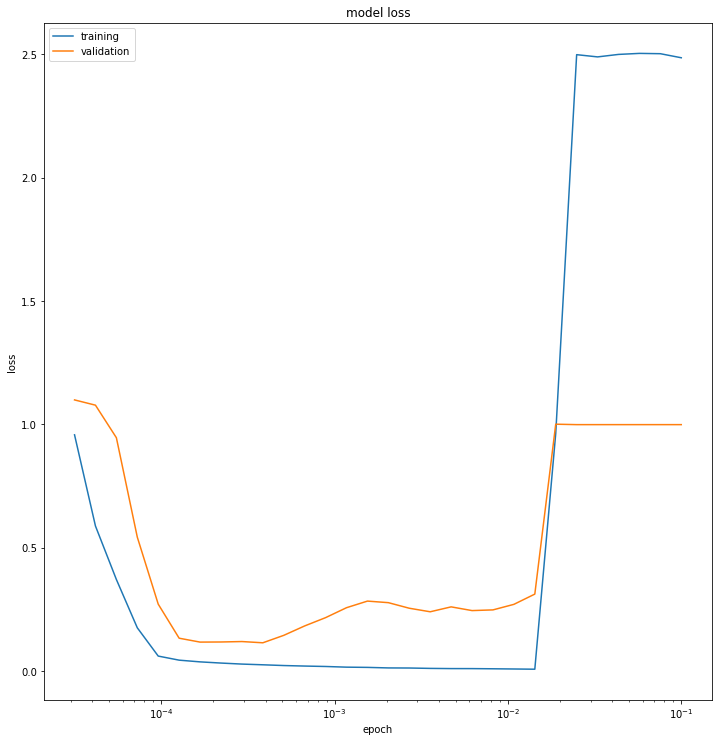

In [30]:
plt.subplots(figsize=(10,10))
plt.tight_layout()
viz.display_training_curves(
    history_lr_rate_range_test.history['loss'], history_lr_rate_range_test.history['val_loss'], 'loss', 111, x=np.logspace(-4.5, -1, 30)
)
plt.xscale('log')

# Training


In [19]:
model = tf.keras.models.load_model(str(model_paths.autosaved_model_path) + ".hdf5")

In [30]:
lr = 0.001

from keras import backend as K
K.set_value(model.optimizer.learning_rate, lr)

cb = [
    autosave_cb,
    logger_cb,
    callbacks.TerminateOnNaN(),
    reduce_lr_cb,
#     lr_range_test_schedule_cb
]

train_generator.force_shorter_epoch = 100

6.309573444801929e-05


In [31]:
history = model.fit(
    x=train_generator,
    validation_data=val_generator,
    validation_steps=100,  # todo put in summary
    epochs=40,  # todo put this in variable
    callbacks=cb,  # todo mention in summary...
    verbose=1,
    use_multiprocessing=False,   # todo add to summary
    # class_weight=class_freqs_inv,  # todo better with actual images !!!!!!!!!!!!!!!!!!!!!
    initial_epoch=30,
)

Epoch 31/40
INFO:tensorflow:batch_all_reduce: 135 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 135 all-reduces with algorithm = nccl, num_packs = 1
562/562 [==============================] - 625s 1s/step - loss: 0.0196 - val_loss: 0.1656 - lr: 6.3096e-05
Epoch 32/40
562/562 [==============================] - 507s 902ms/step - loss: 0.0160 - val_loss: 0.1819 - lr: 6.3096e-05
Epoch 33/40
562/562 [==============================] - 506s 901ms/step - loss: 0.0140 - val_loss: 0.1996 - lr: 6.3096e-05
Epoch 34/40
562/562 [==============================] - 507s 902ms/step - loss: 0.0127 - val_loss: 0.2132 - lr: 6.3096e-05
Epoch 35/40
562/562 [==============================] - 508s 904ms/step - loss: 0.0115 - val_loss: 0.2240 - lr: 6.3096e-05
Epoch 36/40
562/562 [==============================] - ETA: 0s - loss: 0.0108
Epoch 00036: ReduceLROnPlateauBacktrack reducinglearning rate to 3.15478682750836e-05 and backtracking.
562/562 [============================

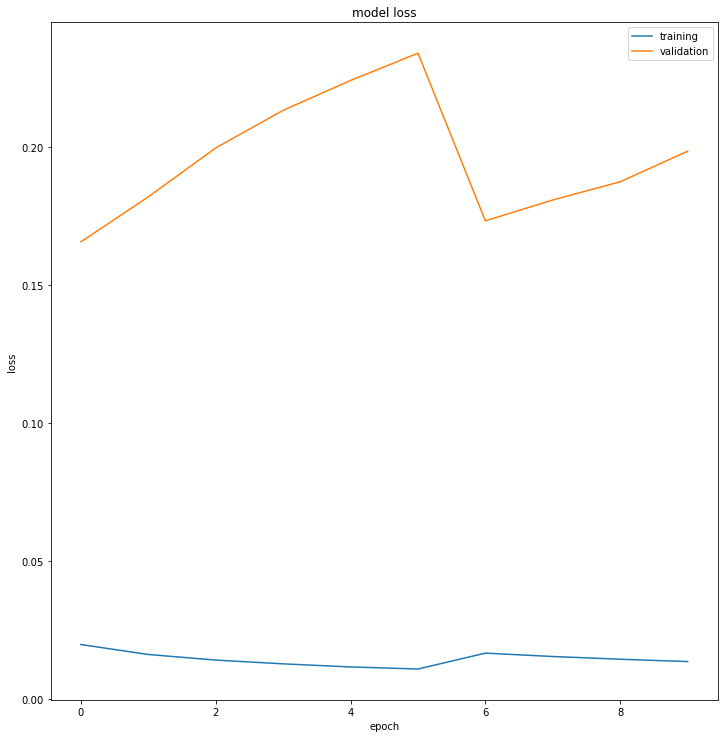

In [36]:
plt.subplots(figsize=(10,10))
plt.tight_layout()
viz.display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 111)

# Training 2nd round

In [37]:
model.optimizer.learning_rate / 2

<tf.Tensor: shape=(), dtype=float32, numpy=7.886967e-06>

In [38]:
reduce_lr_cb = ReduceLROnPlateauBacktrack(
    model,
    str(model_paths.autosaved_model_path) + ".hdf5",  # todo move this to inside ModelPaths 
    monitor="val_loss",
    factor=0.5,
    patience=4,
    verbose=1,
    mode="auto",
    min_delta=0,
    min_lr=1e-5,
)

lr = 1.5773934e-05

from tensorflow.keras import backend as K
K.set_value(model.optimizer.learning_rate, lr)

cb = [
    autosave_cb,
    logger_cb,
    callbacks.TerminateOnNaN(),
    reduce_lr_cb,
#     lr_range_test_schedule_cb
]

train_generator.force_shorter_epoch = 300

In [39]:
history_2 = model.fit(
    x=train_generator,
    validation_data=val_generator,
    validation_steps=100,  # todo put in summary
    epochs=55,  # todo put this in variable
    callbacks=cb,  # todo mention in summary...
    verbose=1,
    use_multiprocessing=False,   # todo add to summary
    # class_weight=class_freqs_inv,  # todo better with actual images !!!!!!!!!!!!!!!!!!!!!
    initial_epoch=40,
)

Epoch 41/55
300/300 [==============================] - 276s 922ms/step - loss: 0.0130 - val_loss: 0.2000 - lr: 1.5774e-05
Epoch 42/55
300/300 [==============================] - 272s 906ms/step - loss: 0.0127 - val_loss: 0.2018 - lr: 1.5774e-05
Epoch 43/55
300/300 [==============================] - 273s 909ms/step - loss: 0.0125 - val_loss: 0.2027 - lr: 1.5774e-05
Epoch 44/55
300/300 [==============================] - 272s 906ms/step - loss: 0.0124 - val_loss: 0.2052 - lr: 1.5774e-05
Epoch 45/55
300/300 [==============================] - ETA: 0s - loss: 0.0122
Epoch 00045: ReduceLROnPlateauBacktrack reducinglearning rate to 1e-05 and backtracking.
300/300 [==============================] - 274s 913ms/step - loss: 0.0122 - val_loss: 0.2074 - lr: 1.5774e-05
Epoch 46/55
300/300 [==============================] - 280s 934ms/step - loss: 0.0171 - val_loss: 0.1630 - lr: 1.0000e-05
Epoch 47/55
300/300 [==============================] - 276s 920ms/step - loss: 0.0168 - val_loss: 0.1657 - lr: 1.

KeyboardInterrupt: 

In [43]:
with mirrored_strategy.scope():
    model = tf.keras.models.load_model(str(model_paths.autosaved_model_path) + ".hdf5")

In [44]:
reduce_lr_cb = ReduceLROnPlateauBacktrack(
    model,
    str(model_paths.autosaved_model_path) + ".hdf5",  # todo move this to inside ModelPaths 
    monitor="val_loss",
    factor=2./3,
    patience=3,
    verbose=1,
    mode="auto",
    min_delta=0,
    min_lr=1e-7,
)

lr = 1e-05

from tensorflow.keras import backend as K
K.set_value(model.optimizer.learning_rate, lr)

cb = [
    autosave_cb,
    logger_cb,
    callbacks.TerminateOnNaN(),
    reduce_lr_cb,
#     lr_range_test_schedule_cb
]

train_generator.force_shorter_epoch = None

In [46]:
model.save(model_paths.model_path)

INFO:tensorflow:Assets written to: /home/users/jcasagrande/projects/tomo2seg/models/dryrun-03/assets


In [ ]:
# todo add metrics 
# todo add wandb?
# todo add analysis in the end, see examples of classif
# todo add callbacks that generate classif examples
# todo print line that I can cccv on the experiments spreadsheet
# todo save the yaml file
# todo (later): separate the analysis part in a separate script so it 
#  can be called at any time with another model
# todo experiment with CentralStorageStrategy?